hg00733.rep.paf.gz
diffs  36
diff max  8314
counts  [735535.25]
[9.9989e+01 0.0000e+00 1.0000e-04 1.0000e-04]
[(92, 230, 0.002), (165, 14, 0.0), (218, 256, 0.001), (229, 8, 0.0), (230, 6, 0.0), (238, 2852, 0.004), (247, 654, 0.004), (355, 79, 0.003), (389, 1871, 0.014), (570, 1, 0.0), (574, 1, 0.0), (624, 18, 0.0), (631, 11, 0.0), (642, 36, 0.001), (675, 3, 0.0), (676, 957, 0.006), (691, 8314, 0.017), (694, 18, 0.0)]
[[567 514 363 280 287 277 283 287 277 280 279 280 280 284 279 288 280 281
  287 280 289 278 279 283 287 280 283 278 284 281 283 280 278 288 280 278
  279 281 281 279 282 282 280 278 279 278 288 340 279 281 281 277 278 281
  279 281 279 282 286 283 299 280 287 277 280 283 277 283 277 283 283 283
  284 278 282 280 286 284 287 298 283 280 279 279 284 282 283 289 287 286
  284 280 278 278 279 288 285 282 280 319]
 [ 72  59   6   0   2   0   3   2   0   0   0   1   0   3   1   2   0   1
    1   0   0   1   0   0   1   0   3   0   0   1   0   1   0   3   0   0
    1   2   1   0 

Text(0, 0.5, 'Contig length difference (bp)')

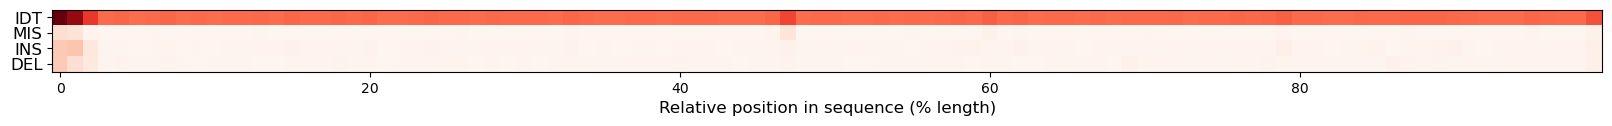

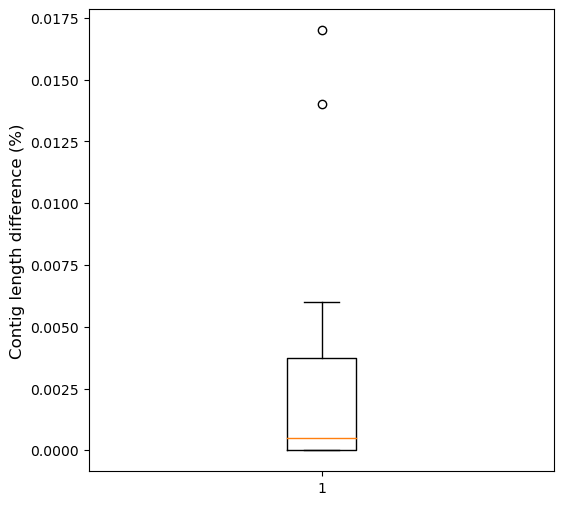

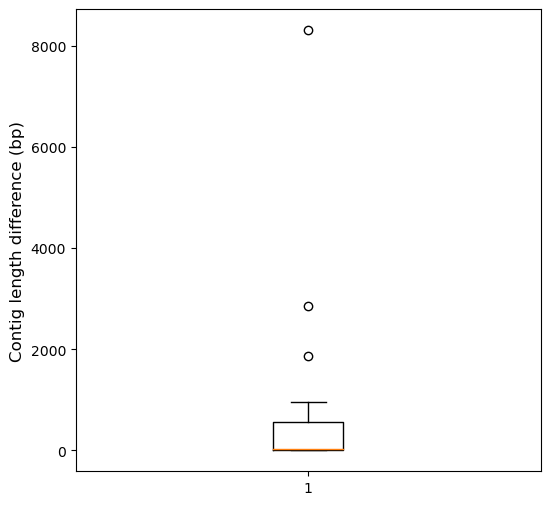

In [6]:
import pandas as pd
import pathlib as pl
import re
import collections as col
import numpy as np
import gzip

input_folder = pl.Path("/home/ebertp/work/projects/hgsvc/2023_verkko_ccc")

op_map = {
    "I": ("INS", 2),
    "D": ("DEL", 3),
    "=": ("IDT", 0),
    "X": ("MIS", 1)
}

def count_cigar_ops(cigar_string, seq_length):
    
    get_num = re.compile("[0-9]+")
    
    op_locations = np.zeros((4, 100), dtype=int)
    
    count_ops = np.zeros(4, dtype=int)
    start_coord = 0
    for cigar_part in re.finditer(get_num, cigar_string):
        s, e = cigar_part.span()
        cigar_code = cigar_string[e:e+1]
        cigar_op, op_row = op_map[cigar_code]
        num_ops = int(cigar_part.group(0))
        count_ops[op_row] += num_ops
        seq_pct_start = int(round(start_coord / seq_length * 100))
        seq_pct_end = int(round((start_coord + num_ops)/seq_length * 100))
        if seq_pct_start == seq_pct_end:
            seq_pct_end += 1
        op_locations[op_row, seq_pct_start:seq_pct_end] += 1
        start_coord += num_ops
        
    op_freq = (count_ops / seq_length * 100).round(2)
    return count_ops, op_freq, op_locations
        


for paf in input_folder.glob("*.paf.gz"):
    if "red" in paf.name:
        continue
    if "rep" not in paf.name:
        continue
    print(paf.name)
    aln_ops = np.zeros((4, 100), dtype=int)
    contig_mismatches = []
    processed_aln = 0
    processed_contigs = col.defaultdict(set)
    skipped_contigs = col.defaultdict(set)
    perfect_match_count = 0
    perfect_match_bp = 0
    imperfect_match_count = 0
    imperfect_match_bp = 0
    op_frequency = []
    op_counts = []
    with gzip.open(paf, "rt") as paf_aln:
        for ln, line in enumerate(paf_aln, start=1):
            if not line.strip():
                continue
            parts = line.strip().split()
            qry_name = parts[0]
            trg_name = parts[5]
            qry_len, trg_len = int(parts[1]), int(parts[6])
            
            if qry_len < int(5e5) or trg_len < int(5e5):
                continue
            
            aln_qry = (int(parts[3]) - int(parts[2])) / qry_len
            aln_trg = (int(parts[8]) - int(parts[7])) / trg_len
            
            if aln_trg < 0.95 or aln_qry < 0.95:
                skipped_contigs["target"].add(trg_name)
                skipped_contigs["query"].add(qry_name)
                continue
            
            if not trg_len == qry_len:
                midsize = (trg_len + qry_len)//2
                size_gap = abs(trg_len - qry_len)
                size_gap_pct = round(size_gap / midsize * 100, 3)
                contig_mismatches.append((ln, size_gap, size_gap_pct))
                imperfect_match_count += 1
                imperfect_match_bp += midsize
            else:
                perfect_match_count += 1
                perfect_match_bp += trg_len
            #assert trg_name == qry_name, f"LN {ln}: {trg_name} vs {qry_name}"
            cigar_string = parts[-1]
            assert cigar_string.startswith("cg:Z:")
            count_ops, op_freq, op_locs = count_cigar_ops(cigar_string, max(trg_len, qry_len))
            op_frequency.append(op_freq)
            aln_ops += op_locs
            processed_aln += 1
            processed_contigs["target"].add(trg_name)
            processed_contigs["query"].add(qry_name)
            
    op_frequency = np.vstack(op_frequency)
    op_counts = np.vstack(count_ops)
    size_diffs = np.array([t[1] for t in contig_mismatches], dtype=int)
    size_diffs.sort()
    print("diffs ", size_diffs[size_diffs.size//2])
    print("diff max ", size_diffs.max())
    print("counts ", op_counts.mean(axis=0).round(4))
    print(op_frequency.mean(axis=0).round(4))
    print(contig_mismatches)
    print(aln_ops)
    print(processed_aln)
    print(perfect_match_count, " - ", imperfect_match_count)
    print(perfect_match_bp, " - ", imperfect_match_bp)
    
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,30))
im = ax.imshow(aln_ops, cmap="Reds")

ax.set_xlabel("Relative position in sequence (% length)", fontsize=12)
ax.set_yticks(np.arange(aln_ops.shape[0]), labels=["IDT", "MIS", "INS", "DEL"], fontsize=12)


fig, ax = plt.subplots(figsize=(6,6))

ax.boxplot([t[2] for t in contig_mismatches])
ax.set_ylabel("Contig length difference (%)", fontsize=12)

fig, ax = plt.subplots(figsize=(6,6))

ax.boxplot([t[1] for t in contig_mismatches])
ax.set_ylabel("Contig length difference (bp)", fontsize=12)

